In [1]:
import os
# Kaggle API key
os.environ['KAGGLE_CONFIG_DIR'] = 'C:/Users/itadi/Desktop/Python'

In [41]:
import kaggle
import pandas as pd
import numpy as np
from tqdm import tqdm 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from wordcloud import WordCloud

In [3]:
# Download dataset from Kaggle
def downloadDataset():

    """
    Download dataset from Kaggle
    """

    dataset = 'kazanova/sentiment140'

    downloadPath = './dataset'
    if not os.path.exists(downloadPath):
        os.makedirs(downloadPath)

    for file in tqdm(os.listdir(downloadPath), desc="Processing files"):
        filePath = os.path.join(downloadPath, file)
        try:
            if os.path.isfile(filePath):
                os.unlink(filePath)
                print('Old files deleted successfully!')
        except Exception as e:
            print(f'Failed to delete {filePath}. Reason: {e}')
        
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(dataset, path=downloadPath, unzip=True)

    print('Dataset downloaded successfully!')

# Download dataset
downloadDataset()

Processing files: 100%|██████████| 1/1 [00:00<00:00, 859.66it/s]


Old files deleted successfully!
Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
Dataset downloaded successfully!


In [4]:
nltk.download('stopwords');
# Print stopwords in English
# Does not add any value to the text data
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\itadi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Load dataset
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
dataset = pd.read_csv('./dataset/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None, names=column_names)

In [6]:
# Shape of the dataset
print(f'Shape of the dataset: {dataset.shape}')
# Display columns in the dataset
print(f'Columns in the dataset: {dataset.columns}')

Shape of the dataset: (1600000, 6)
Columns in the dataset: Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')


In [7]:
# Display first 5 rows of the dataset
dataset.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
# Check for missing values
print(f'Missing values in the dataset: \n{dataset.isnull().sum()}')

Missing values in the dataset: 
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64


In [9]:
# Print unique values in the target column
print(f'Unique values in the target column: {dataset.target.unique()}')
# Print value counts in the target column
print(f'Value counts in the target column: \n{dataset.target.value_counts()}')

Unique values in the target column: [0 4]
Value counts in the target column: 
target
0    800000
4    800000
Name: count, dtype: int64


In [10]:
# Converting target values to 0 and 1
dataset['target'] = dataset['target'].replace({4: 1})

# 0: Negative sentiment
# 1: Positive sentiment

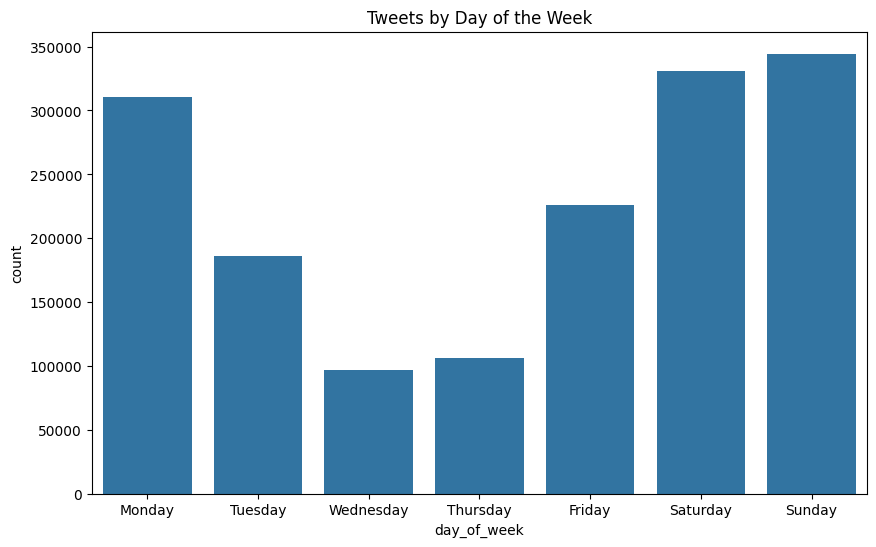

In [35]:
# Ensure the date is in datetime format
dataset['date'] = pd.to_datetime(dataset['date'])

# Extract date-related features
dataset['year'] = dataset['date'].dt.year
dataset['month'] = dataset['date'].dt.month
dataset['day'] = dataset['date'].dt.day
dataset['hour'] = dataset['date'].dt.hour
dataset['day_of_week'] = dataset['date'].dt.day_name()

# Plot tweet frequency by day
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=dataset, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Tweets by Day of the Week')
plt.show()


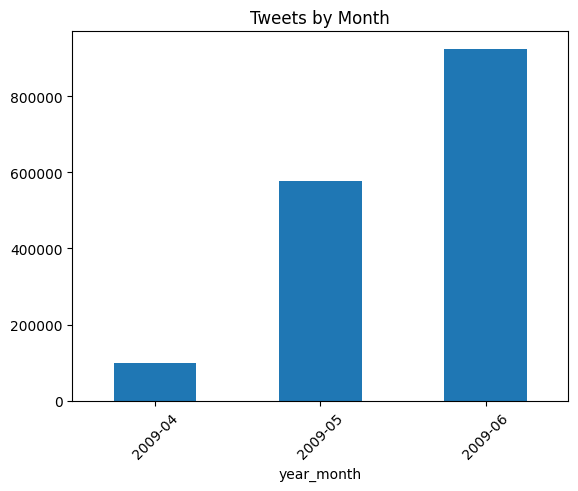

In [33]:
# Group by year and month
dataset['year_month'] = dataset['date'].dt.to_period('M')

# Plot tweet count per month
dataset['year_month'].value_counts().sort_index().plot(kind='bar')
plt.title('Tweets by Month')
plt.xticks(rotation=45)
plt.show()


In [37]:
import re

# Remove URLs, special characters, and mentions
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text

dataset['clean_text'] = dataset['text'].apply(clean_text)

# Preview the cleaned text
dataset[['text', 'clean_text']].head()

,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww thats a bummer You shoulda got David ...
1,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sa...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i he...


In [ ]:
# Join all tweets into one string
all_words = ' '.join([text for text in df['clean_text']])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Tweets')
plt.show()


### Stemming

In [11]:
# Stemming is the process of reducing a word to its root form by removing suffixes. Example: "running" -> "run"
# The Porter stemming algorithm is the most widely used method for stemming in English
# Due to the large size of the dataset, stemming helps in reducing the size of the dataset by reducing the number of unique words

In [12]:
porter = PorterStemmer()
# Precompile regex for better performance
regex = re.compile('[^a-zA-Z]')

# Stopwords as a set (for faster lookups)
stop_words = set(stopwords.words('english'))

def stemming(text):
    """
    Stemming the text
    """
    stemmed_text = regex.sub(' ', text)  # Remove special characters and numbers
    stemmed_text = stemmed_text.lower()  # Convert text to lowercase
    stemmed_text = stemmed_text.split()  # Split into words
    stemmed_text = [porter.stem(word) for word in stemmed_text if word not in stop_words]  # Stemming & stopword removal
    return ' '.join(stemmed_text)

# Parallel processing using joblib to speed up
def parallelize_dataframe(dataset, func, n_jobs=4):
    n_jobs = n_jobs if n_jobs > 0 else os.cpu_count()  # Set number of jobs
    dataset_split = np.array_split(dataset, n_jobs)  # Split dataframe
    # Apply func to each row of the dataframe
    dataset = pd.concat(Parallel(n_jobs=n_jobs)(delayed(lambda d: d.apply(func))(chunk) for chunk in dataset_split))
    return dataset


# Now pass only the stemming function, not the apply() result
dataset['stemmed_text'] = parallelize_dataframe(dataset['text'], stemming)


c:\Users\itadi\Desktop\Python\X-SentimentAnalysis\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [13]:
dataset.head()

,target,ids,date,flag,user,text,stemmed_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [14]:
processed_dataset = dataset[['target', 'stemmed_text']]

In [15]:
X = processed_dataset['stemmed_text']
y = processed_dataset['target']

In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

Training set: 
target
1    600171
0    599829
Name: count, dtype: int64
Testing set: 
target
0    200171
1    199829
Name: count, dtype: int64


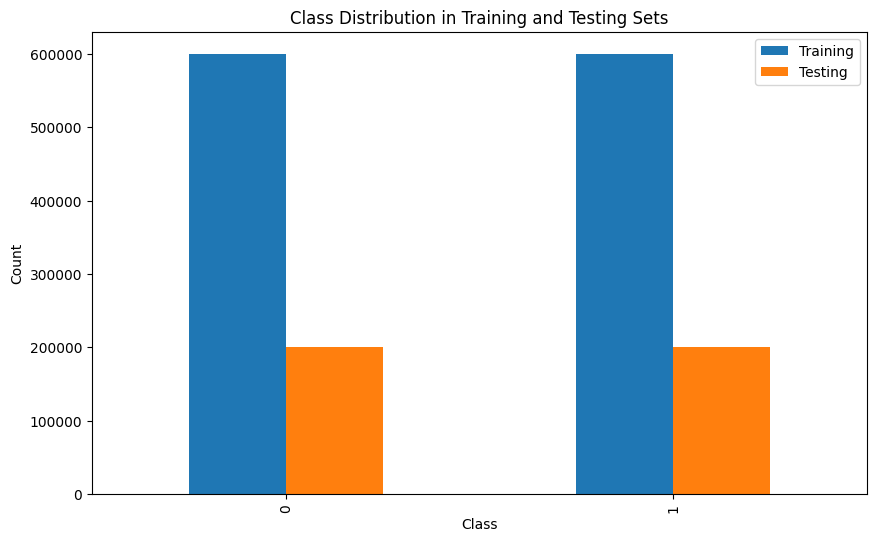

In [17]:
# Verify distribution of classes in training and testing sets
print(f'Training set: \n{y_train.value_counts()}')
print(f'Testing set: \n{y_test.value_counts()}')

# Visualize distribution of classes in training and testing sets
# Combine data into a DataFrame for easier plotting
train_test_counts = pd.DataFrame({
    'Training': y_train.value_counts(),
    'Testing': y_test.value_counts()
})

# Plot a grouped bar chart
train_test_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Class Distribution in Training and Testing Sets')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()


In [18]:
# Convert text data to numerical data using TF-Idataset (TfidatasetVectorizer)

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train) # fit_transform is used to learn the vocabulary from the training data and then transform it
X_test = vectorizer.transform(X_test) # transform is applied to the test data using the same learned vocabulary

In [19]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [21]:
train_predictions = model.predict(X_train)
accuracy_train_preds = accuracy_score(y_train, train_predictions)
print(f'Training accuracy: {accuracy_train_preds}')

Training accuracy: 0.7993208333333334


In [22]:
test_predictions = model.predict(X_test)
accuracy_test_preds = accuracy_score(y_test, test_predictions)
print(f'Test accuracy: {accuracy_test_preds}')

Test accuracy: 0.77659


In [26]:
# Save the model
model_name = 'sentiment_analysis_model.pkl'
pickle.dump(model, open(model_name, 'wb'))